In [2]:
import pandas as pd
import numpy as np
from PyALE import ale
import joblib
from sklearn.preprocessing import OneHotEncoder

In [3]:
xgb = joblib.load("models/XGBClassifier_ohe_mode_allcat.pkl")
df = pd.read_csv("in-vehicle-coupon-recommendation.csv")
df_ohe = pd.read_csv("data/ohe_mode_allcat.csv")

ohe_col = ['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp']

In [4]:
df_ohe.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
def fillnull(col):
    col.fillna(col.value_counts().index[0], inplace=True)
    return col

df = df.apply(lambda col: fillnull(col))

In [6]:
df_ohe.columns

Index(['destination_Home', 'destination_No Urgent Place', 'destination_Work',
       'passanger_Alone', 'passanger_Friend(s)', 'passanger_Kid(s)',
       'passanger_Partner', 'weather_Rainy', 'weather_Snowy', 'weather_Sunny',
       ...
       'toCoupon_GEQ5min_1', 'toCoupon_GEQ15min_0', 'toCoupon_GEQ15min_1',
       'toCoupon_GEQ25min_0', 'toCoupon_GEQ25min_1', 'direction_same_0',
       'direction_same_1', 'direction_opp_0', 'direction_opp_1', 'Y'],
      dtype='object', length=128)

In [7]:
# df transformation
df['temperature'] = df['temperature'].astype(object)
for i in df.columns[:-1]:
    df[i] = f'{i}_' + df[i].astype(str)

In [8]:
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,destination_No Urgent Place,passanger_Alone,weather_Sunny,temperature_55,time_2PM,coupon_Restaurant(<20),expiration_1d,gender_Female,age_21,maritalStatus_Unmarried partner,...,CoffeeHouse_never,CarryAway_1~3,RestaurantLessThan20_4~8,Restaurant20To50_1~3,toCoupon_GEQ5min_1,toCoupon_GEQ15min_0,toCoupon_GEQ25min_0,direction_same_0,direction_opp_1,1
1,destination_No Urgent Place,passanger_Friend(s),weather_Sunny,temperature_80,time_10AM,coupon_Coffee House,expiration_2h,gender_Female,age_21,maritalStatus_Unmarried partner,...,CoffeeHouse_never,CarryAway_1~3,RestaurantLessThan20_4~8,Restaurant20To50_1~3,toCoupon_GEQ5min_1,toCoupon_GEQ15min_0,toCoupon_GEQ25min_0,direction_same_0,direction_opp_1,0
2,destination_No Urgent Place,passanger_Friend(s),weather_Sunny,temperature_80,time_10AM,coupon_Carry out & Take away,expiration_2h,gender_Female,age_21,maritalStatus_Unmarried partner,...,CoffeeHouse_never,CarryAway_1~3,RestaurantLessThan20_4~8,Restaurant20To50_1~3,toCoupon_GEQ5min_1,toCoupon_GEQ15min_1,toCoupon_GEQ25min_0,direction_same_0,direction_opp_1,1
3,destination_No Urgent Place,passanger_Friend(s),weather_Sunny,temperature_80,time_2PM,coupon_Coffee House,expiration_2h,gender_Female,age_21,maritalStatus_Unmarried partner,...,CoffeeHouse_never,CarryAway_1~3,RestaurantLessThan20_4~8,Restaurant20To50_1~3,toCoupon_GEQ5min_1,toCoupon_GEQ15min_1,toCoupon_GEQ25min_0,direction_same_0,direction_opp_1,0
4,destination_No Urgent Place,passanger_Friend(s),weather_Sunny,temperature_80,time_2PM,coupon_Coffee House,expiration_1d,gender_Female,age_21,maritalStatus_Unmarried partner,...,CoffeeHouse_never,CarryAway_1~3,RestaurantLessThan20_4~8,Restaurant20To50_1~3,toCoupon_GEQ5min_1,toCoupon_GEQ15min_1,toCoupon_GEQ25min_0,direction_same_0,direction_opp_1,0


In [9]:
from pyale import hyeni_pyale

PyALE._ALE_generic:INFO: categorical feature detected.


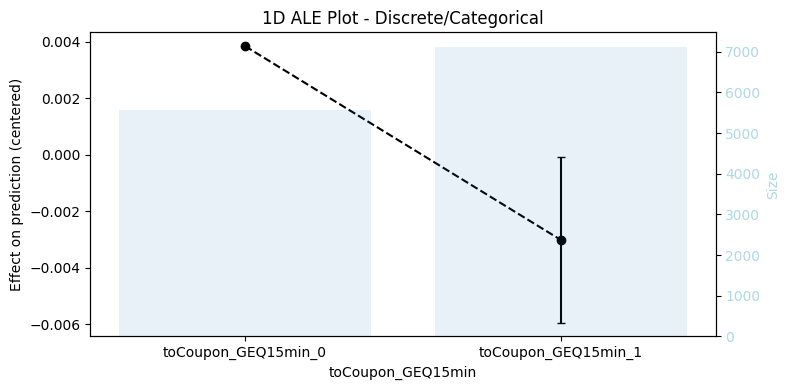

In [10]:
ale_col = 'toCoupon_GEQ15min'
ohe = OneHotEncoder()
coded_feature = pd.DataFrame(ohe.fit_transform(df[[ale_col]]).toarray(),columns=[x for i in ohe.categories_ for x in i])
features = df_ohe.columns.tolist()
features.remove("Y")

X_feat_raw = df_ohe.drop(coded_feature.columns.to_list(), axis=1, inplace=False).copy()
X_feat_raw

one_hot_encoder = OneHotEncoder().fit(df[[ale_col]])

def onehot_encode(feat, ohe=one_hot_encoder):
    col_names = ohe.categories_[0]
    feat_coded = pd.DataFrame(ohe.transform(feat).toarray())
    feat_coded.columns = col_names
    return feat_coded

ale_eff = ale(
        X=pd.concat([X_feat_raw,df[ale_col]], axis=1).drop(columns=['Y']),
        model=xgb.best_estimator_.named_steps.model,
        feature=[ale_col],
        encode_fun=onehot_encode,
        predictors=features,
)

PyALE._ALE_generic:INFO: categorical feature detected.


,eff,size,lowerCI_95%,upperCI_95%
temperature,,,,
temperature_80,-0.002445,6528,NaN,NaN
temperature_55,0.009804,3840,0.007003,0.012605
temperature_30,-0.009364,2316,-0.014106,-0.004622


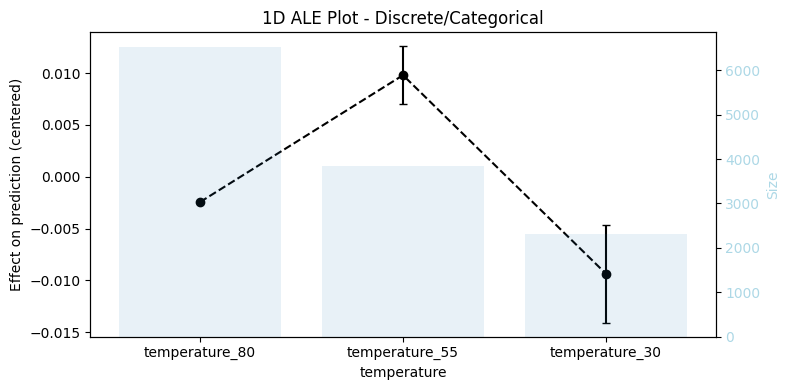

In [15]:
hyeni_pyale(df,df_ohe,xgb,'temperature')